# Performance Models and Impact with Compression of Job-Data with K-Means-Clustering

In [15]:
import sys
sys.path.insert(0, '..')
import collections

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from IPython.display import display, HTML
from ipywidgets import IntProgress

from RuntimePrediction.Predict import Predictor as C3OPredictor
from RuntimePrediction.DefaultModels import (GradientBoosting as GB,
                                             ErnestModel as EM)
from RuntimePrediction.CustomModels import (BasicOptimisticModel as BOM,
                                            OptimisticGradientBoosting as OGB)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score

## Extract Runtime Data

In [16]:
kmeans_df = pd.read_csv('../data/kmeans.tsv')
sort_df = pd.read_csv('../data/sort.tsv')
grep_df = pd.read_csv('../data/grep.tsv')
sgd_df = pd.read_csv('../data/sgd.tsv')
pagerank_df = pd.read_csv('../data/pagerank.tsv')

## 1. Compression: Filter and remove duplicate datapoints

In [3]:
kmeans_compression_0 = kmeans_df.shape[0]
sort_compression_0 = sort_df.shape[0]
grep_compression_0 = grep_df.shape[0]
sgd_compression_0 = sgd_df.shape[0]
pagerank_compression_0 = pagerank_df.shape[0]

kmeans_df.drop_duplicates(inplace=True)
sort_df.drop_duplicates(inplace=True)
grep_df.drop_duplicates(inplace=True)
sgd_df.drop_duplicates(inplace=True)
pagerank_df.drop_duplicates(inplace=True)

kmeans_df.to_csv('../data/reduced-kmeans_1.tsv', index=False)
sort_df.to_csv('../data/reduced-sort_1.tsv', index=False)
grep_df.to_csv('../data/reduced-grep_1.tsv', index=False)
sgd_df.to_csv('../data/reduced-sgd_1.tsv', index=False)
pagerank_df.to_csv('../data/reduced-pagerank_1.tsv', index=False)

kmeans_compression_1 = round(1 - (kmeans_df.shape[0])/kmeans_compression_0, 4)
sort_compression_1 = round(1 - (sort_df.shape[0])/sort_compression_0, 4)
grep_compression_1 = round(1 - (grep_df.shape[0])/grep_compression_0, 4)
sgd_compression_1 = round(1 - (sgd_df.shape[0])/sgd_compression_0, 4)
pagerank_compression_1 = round(1 - (pagerank_df.shape[0])/pagerank_compression_0, 4)

kmeans_dp = kmeans_df.shape[0]
sort_dp = sort_df.shape[0]
grep_dp = grep_df.shape[0]
sgd_dp = sgd_df.shape[0]
pagerank_dp = pagerank_df.shape[0]

print("KMeans: First Compression: " + str(kmeans_compression_1) + " Datapoints: " + str(kmeans_df.shape[0]))
print("Sort: First Compression: " + str(sort_compression_1) + " Datapoints: " + str(sort_df.shape[0]))
print("Grep: First Compression: " + str(grep_compression_1) + " Datapoints: " + str(grep_df.shape[0]))
print("Sgd: First Compression: " + str(sgd_compression_1) + " Datapoints: " + str(sgd_df.shape[0]))
print("Pagerank: First Compression: " + str(pagerank_compression_1) + " Datapoints: " + str(pagerank_df.shape[0]))

KMeans: First Compression: 0.2733 Datapoints: 654
Sort: First Compression: 0.2873 Datapoints: 449
Grep: First Compression: 0.358 Datapoints: 520
Sgd: First Compression: 0.4578 Datapoints: 488
Pagerank: First Compression: 0.1631 Datapoints: 1180


## 2. K-Means Clustering

In [5]:
# Ignore feature 'machine_type'
kmeans_machine_type_column= pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t', usecols=range(1,2))
sort_machine_type_column= pd.read_csv('../data/reduced-sort_1.tsv', sep='\t', usecols=range(1,2))
grep_machine_type_column= pd.read_csv('../data/reduced-grep_1.tsv', sep='\t', usecols=range(1,2))
sgd_machine_type_column= pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t', usecols=range(1,2))
pagerank_machine_type_column= pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t', usecols=range(1,2))

kmeans_headers = [*pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t', nrows=1)]
reducedKmeans = pd.read_csv('../data/reduced-kmeans_1.tsv', sep='\t', usecols=[c for c in kmeans_headers if c != 'machine_type'])

sort_headers = [*pd.read_csv('../data/reduced-sort_1.tsv', sep='\t', nrows=1)]
reducedSort = pd.read_csv('../data/reduced-sort_1.tsv', sep='\t', usecols=[c for c in sort_headers if c != 'machine_type'])

grep_headers = [*pd.read_csv('../data/reduced-grep_1.tsv', sep='\t', nrows=1)]
reducedGrep = pd.read_csv('../data/reduced-grep_1.tsv', sep='\t', usecols=[c for c in grep_headers if c != 'machine_type'])

sgd_headers = [*pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t', nrows=1)]
reducedSgd = pd.read_csv('../data/reduced-sgd_1.tsv', sep='\t', usecols=[c for c in sgd_headers if c != 'machine_type'])

pagerank_headers = [*pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t', nrows=1)]
reducedPagerank = pd.read_csv('../data/reduced-pagerank_1.tsv', sep='\t', usecols=[c for c in pagerank_headers if c != 'machine_type'])

In [67]:
# create Clusters with KMeans // n_clusters => e.g. 200,150,100,45,35,25,15 // set random_state=0 for no random Points
km_kmeans = KMeans(n_clusters=200).fit(reducedKmeans)
km_sort = KMeans(n_clusters=200).fit(reducedSort)
km_grep = KMeans(n_clusters=200).fit(reducedGrep)
km_sgd = KMeans(n_clusters=200).fit(reducedSgd)
km_pagerank = KMeans(n_clusters=200).fit(reducedPagerank)

# Calculate Silhoutte Score for optimal n_cluster
kmeans_score = silhouette_score(reducedKmeans, km_kmeans.labels_, metric='euclidean')
sort_score = silhouette_score(reducedSort, km_sort.labels_, metric='euclidean')
grep_score = silhouette_score(reducedGrep, km_grep.labels_, metric='euclidean')
sgd_score = silhouette_score(reducedSgd, km_sgd.labels_, metric='euclidean')
pagerank_score = silhouette_score(reducedPagerank, km_pagerank.labels_, metric='euclidean')

print('Silhouetter Score KMeans: %.3f' % kmeans_score)
print('Silhouetter Score Sort: %.3f' % sort_score)
print('Silhouetter Score Grep: %.3f' % grep_score)
print('Silhouetter Score Sgd: %.3f' % sgd_score)
print('Silhouetter Score Pagerank: %.3f' % pagerank_score)

# Get Centroids of the current clusters
centralKmeans, _ = pairwise_distances_argmin_min(km_kmeans.cluster_centers_, reducedKmeans)
centralSort, _ = pairwise_distances_argmin_min(km_sort.cluster_centers_, reducedSort)
centralGrep, _ = pairwise_distances_argmin_min(km_grep.cluster_centers_, reducedGrep)
centralSgd, _ = pairwise_distances_argmin_min(km_sgd.cluster_centers_, reducedSgd)
centralPagerank, _ = pairwise_distances_argmin_min(km_pagerank.cluster_centers_, reducedPagerank)

# Just filter the centroid rows of current dataset and add feature machine_type back
kmeans_dataset = pd.read_csv("../data/reduced-kmeans_1.tsv")
sort_dataset = pd.read_csv("../data/reduced-sort_1.tsv")
grep_dataset = pd.read_csv("../data/reduced-grep_1.tsv")
sgd_dataset = pd.read_csv("../data/reduced-sgd_1.tsv")
pagerank_dataset = pd.read_csv("../data/reduced-pagerank_1.tsv")

kmeans_machine_type_column.join(kmeans_dataset)
kmeans_filter_centroids = kmeans_dataset.iloc[centralKmeans].sort_index(0, ascending=True)
kmeans_filter_centroids.to_csv('../data/reduced-kmeans_200.tsv', index=False)

sort_machine_type_column.join(sort_dataset)
sort_filter_centroids = sort_dataset.iloc[centralSort].sort_index(0, ascending=True)
sort_filter_centroids.to_csv('../data/reduced-sort_200.tsv', index=False)

grep_machine_type_column.join(grep_dataset)
grep_filter_centroids = grep_dataset.iloc[centralGrep].sort_index(0, ascending=True)
grep_filter_centroids.to_csv('../data/reduced-grep_200.tsv', index=False)

sgd_machine_type_column.join(sgd_dataset)
sgd_filter_centroids = sgd_dataset.iloc[centralSgd].sort_index(0, ascending=True)
sgd_filter_centroids.to_csv('../data/reduced-sgd_200.tsv', index=False)

pagerank_machine_type_column.join(pagerank_dataset)
pagerank_filter_centroids = pagerank_dataset.iloc[centralPagerank].sort_index(0, ascending=True)
pagerank_filter_centroids.to_csv('../data/reduced-pagerank_200.tsv', index=False)

Silhouetter Score KMeans: 0.984
Silhouetter Score Sort: 0.607
Silhouetter Score Grep: 0.765
Silhouetter Score Sgd: 0.665
Silhouetter Score Pagerank: 0.719


In [4]:
# compression and datapoints in the current datasets
kmeans_compression_2 = pd.read_csv('../data/reduced-kmeans_200.tsv')
sort_compression_2 = pd.read_csv('../data/reduced-sort_200.tsv')
grep_compression_2 = pd.read_csv('../data/reduced-grep_200.tsv')
sgd_compression_2 = pd.read_csv('../data/reduced-sgd_200.tsv')
pagerank_compression_2 = pd.read_csv('../data/reduced-pagerank_200.tsv')

kmeans_compression_K = round(1 - (kmeans_compression_2.shape[0])/kmeans_compression_0, 4)
sort_compression_K = round(1 - (sort_compression_2.shape[0])/sort_compression_0, 4)
grep_compression_K = round(1 - (grep_compression_2.shape[0])/grep_compression_0, 4)
sgd_compression_K = round(1 - (sgd_compression_2.shape[0])/sgd_compression_0, 4)
pagerank_compression_K = round(1 - (pagerank_compression_2.shape[0])/pagerank_compression_0, 4)

print("KMeans: Compression: " + str(kmeans_compression_K) + " Datapoints: " + str(kmeans_compression_2.shape[0]))
print("Sort: Compression: " + str(sort_compression_K) + " Datapoints: " + str(sort_compression_2.shape[0]))
print("Grep: Compression: " + str(grep_compression_K) + " Datapoints: " + str(grep_compression_2.shape[0]))
print("Sgd: Compression: " + str(sgd_compression_K) + " Datapoints: " + str(sgd_compression_2.shape[0]))
print("Pagerank: Compression: " + str(pagerank_compression_K) + " Datapoints: " + str(pagerank_compression_2.shape[0]))

KMeans: Compression: 0.7778 Datapoints: 200
Sort: Compression: 0.6825 Datapoints: 200
Grep: Compression: 0.7531 Datapoints: 200
Sgd: Compression: 0.7778 Datapoints: 200
Pagerank: Compression: 0.8582 Datapoints: 200


## Define Models

In [3]:
Model = collections.namedtuple('Model', ['name', 'predictor', 'kwargs'])

models = [
          Model('Ernest', EM, {}),
          Model('GBM', GB, {}), 
          
          Model('BOM', BOM, {}), 
          Model('OGB', OGB, {}), 
   
          Model('C3O', C3OPredictor, {}),
         ]

## Extract Runtime Data

In [4]:
kmeans_df = pd.read_csv('../data/reduced-kmeans_200.tsv', sep='\t')
sort_df = pd.read_csv('../data/reduced-sort_200.tsv', sep='\t')
grep_df = pd.read_csv('../data/reduced-grep_200.tsv', sep='\t')
sgd_df = pd.read_csv('../data/reduced-sgd_200.tsv', sep='\t')
pagerank_df = pd.read_csv('../data/reduced-pagerank_200.tsv', sep='\t')

kmeans_dp = kmeans_df.shape[0]
sort_dp = sort_df.shape[0]
grep_dp = grep_df.shape[0]
sgd_dp = sgd_df.shape[0]
pagerank_dp = pagerank_df.shape[0]

print(kmeans_dp)
print(sort_dp)
print(grep_dp)
print(sgd_dp)
print(pagerank_dp)

200
200
200
200
200


In [5]:
Job = collections.namedtuple('Job', ['name', 'X', 'y'])

def get_training_data(df, features, filters):
    # Get medians
    g = df.groupby(by=['instance_count','machine_type']+features)
    df = pd.DataFrame(g.median().to_records())
    # Apply filters
    # e.g. only for one machine type each, the full c3o-experiments were conducted
    # No full cartesian product!
    for k, s, v in filters:
        if s == '==': df = df[df[k] == v]
        if s == '>' : df = df[df[k] >  v]
    X = df[['instance_count'] + features]
    y = (df[['gross_runtime']]).squeeze()
    return X, y

td = get_training_data
jobs = [
    Job('Sort',
        *(td(sort_df,
          ['data_size_MB'],
          [('machine_type', '==', 'c4.2xlarge'),
            ('line_length', '==', 100)] )) ),
    Job('Grep',
       *(td(grep_df,
           ['data_size_MB', 'p_occurrence'],
            [('machine_type', '==', 'm4.2xlarge')] )) ),
    Job('SGDLR',
        *(td(sgd_df,
            ['observations', 'features', 'iterations'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
   Job('K-Means',
        *(td(kmeans_df,
            ['observations', 'features', 'k'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
    Job('Page Rank',
        *(td(pagerank_df,
            ['links', 'pages', 'convergence_criterion'],
            [('machine_type', '==', 'r4.2xlarge')] )) ),
]

## Train-Test Split Creations

In [6]:
def create_partial_training_data(job, splits):
    for _ in range(splits):
        yield train_test_split(job.X,job.y)

### Calculating the Model Prediction Errors

In [7]:
def evaluate(model, X_train, X_test, y_train, y_test, error_metric):
    model_instance = model.predictor(**model.kwargs)
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    error = error_metric(y_test, y_pred)
    return error

In [8]:
def create_new_compression_evaluations(amount):
    with open('compression_results_kmeans.csv', 'at') as f:
        for job in jobs:
            for split in create_partial_training_data(job, splits=amount):
                for model in models:
                    error = evaluate(model, *split, MAPE)
                    if job.name == 'K-Means':
                        f.write(f"{job.name},{model.name},{kmeans_dp},{error}\n")
                    if job.name == 'Sort':
                        f.write(f"{job.name},{model.name},{sort_dp},{error}\n")
                    if job.name == 'Grep':
                        f.write(f"{job.name},{model.name},{grep_dp},{error}\n")
                    if job.name == 'SGDLR':
                        f.write(f"{job.name},{model.name},{sgd_dp},{error}\n")
                    if job.name == 'Page Rank':
                        f.write(f"{job.name},{model.name},{pagerank_dp},{error}\n")

In [74]:
#import time
#start_time = time.time()
create_new_compression_evaluations(amount=200)
# time tracking
#with open('time_tracking.csv', 'at') as f:
#   for job in jobs:
#       for model in models:
#           f.write(f"{job.name},{model.name},{sort_dp},{time.time() - start_time}\n")
#print("--- %s seconds ---" % (time.time() - start_time))

### Display the Results

In [9]:
def read_results(job_name):
    try: results = pd.read_csv('compression_results_kmeans.csv', header=None)
    except: return

    rres = [(job, model, ds, float(mape)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Compression', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Compression'], as_index=False)
    df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job_name].set_index(['Model', 'Compression'])
    # Remove redundant info
    return jobdf.unstack()['MAPE']

def display_job_evaluation(job_name):
    
    try: displaydf = read_results(job_name)
    except: display(HTML(f"<h3>{job_name}</h3> None")); return 
    
    # Style the output to highlight the important information
    def highlight_row_min(row):
        return ['color: black' if cell == min(row) else 'color: dimgray' for cell in row]
    
    def highlight_min(data, color='aquamarine', bold=False):
        # highlight the minimum in a Series or DataFrame
        attr1 = f"background-color: {color}"
        attr2 = f"font-weight: {'bold' if bold else 'normal'}"
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_min = data == data.min()
            return [attr1 if v else '' for v in is_min]
        else:  # from .apply(axis=None)
            is_min = data == data.min().min()
            return pd.DataFrame(np.where(is_min, attr2, ''),
                                index=data.index, columns=data.columns)
        
    table_html = displaydf.style.apply(highlight_row_min,axis=1) \
                                .apply(highlight_min, axis=0, color='aquamarine') \
                                .apply(highlight_min, axis=None, bold=True) \
                                .format("{:.2%}") \
                                ._repr_html_()
    
    display(HTML(f"<h3>{job_name}</h3>" + table_html ))

### Performance of the C3O Predictor and its Constituent Models

In [10]:
for job in jobs:
    display_job_evaluation(job.name)

Compression,15,25,35,45,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200
Model,,,,,,,,,,,,,,,,,,,
BOM,26.62%,18.44%,14.65%,8.35%,27.43%,38.41%,15.60%,2.77%,11.11%,10.98%,7.39%,7.15%,7.60%,7.57%,8.11%,7.84%,7.90%,7.78%,7.73%
C3O,66.32%,20.08%,7.59%,7.10%,5.00%,4.29%,3.56%,3.98%,4.09%,5.63%,5.21%,6.23%,6.57%,6.88%,6.87%,6.83%,6.61%,6.35%,6.66%
Ernest,66.51%,17.26%,7.75%,7.58%,5.00%,4.29%,3.54%,4.38%,4.81%,6.57%,6.16%,6.86%,7.30%,7.47%,7.40%,7.59%,7.32%,7.31%,7.31%
GBM,54.48%,23.87%,14.34%,24.95%,21.20%,39.43%,14.37%,10.02%,7.87%,7.30%,7.06%,8.09%,7.27%,7.37%,7.46%,7.05%,7.44%,7.43%,7.49%
OGB,32.65%,26.22%,23.86%,17.23%,29.82%,54.55%,24.25%,4.01%,9.26%,7.88%,8.52%,7.78%,7.59%,7.58%,9.26%,8.64%,8.15%,9.26%,8.70%


Compression,15,25,35,45,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200
Model,,,,,,,,,,,,,,,,,,,
BOM,14.02%,11.21%,8.85%,11.18%,15.87%,17.26%,19.62%,17.12%,15.61%,17.10%,17.90%,17.31%,16.79%,16.12%,16.72%,16.74%,16.13%,15.33%,15.00%
C3O,14.88%,9.11%,8.77%,11.34%,15.83%,11.86%,14.37%,14.48%,12.68%,12.03%,11.30%,8.28%,7.60%,6.54%,6.21%,5.83%,5.60%,4.99%,4.97%
Ernest,12.74%,8.89%,9.42%,14.42%,33.38%,36.77%,41.61%,40.29%,41.35%,44.27%,41.33%,42.07%,42.85%,40.52%,42.14%,41.16%,41.03%,40.63%,40.44%
GBM,16.66%,13.00%,7.87%,12.59%,18.44%,11.72%,15.61%,15.74%,12.34%,11.43%,11.24%,8.09%,7.48%,6.51%,6.17%,5.77%,5.60%,4.99%,4.97%
OGB,19.89%,16.01%,11.44%,13.81%,20.10%,19.37%,20.74%,18.34%,15.88%,16.96%,16.38%,15.66%,13.73%,13.20%,13.88%,13.82%,13.12%,11.75%,11.26%


Compression,15,25,35,45,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200
Model,,,,,,,,,,,,,,,,,,,
BOM,42.22%,12.40%,11.47%,8.37%,7.17%,9.15%,12.61%,10.33%,13.82%,13.57%,13.37%,12.97%,12.91%,12.97%,13.10%,12.74%,12.75%,12.48%,12.63%
C3O,18.82%,8.39%,9.77%,8.27%,7.14%,9.38%,9.57%,9.44%,7.86%,6.57%,6.83%,5.76%,5.37%,4.39%,4.14%,3.74%,3.38%,3.18%,3.08%
Ernest,18.08%,9.14%,10.42%,12.41%,11.87%,15.99%,20.65%,20.74%,23.73%,23.54%,22.08%,22.08%,22.08%,22.43%,22.43%,22.52%,21.89%,22.18%,21.58%
GBM,50.80%,15.56%,14.92%,12.39%,11.50%,13.66%,10.35%,9.63%,8.55%,7.03%,6.60%,5.54%,5.11%,4.26%,4.04%,3.67%,3.33%,3.16%,3.08%
OGB,40.56%,17.58%,17.88%,14.97%,13.05%,11.77%,11.20%,11.42%,11.65%,10.15%,11.04%,9.25%,6.94%,6.94%,6.99%,6.78%,6.55%,6.96%,6.93%


Compression,15,25,35,45,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200
Model,,,,,,,,,,,,,,,,,,,
BOM,20.47%,22.68%,7.75%,6.78%,5.99%,6.09%,7.82%,10.09%,9.18%,8.00%,5.71%,6.64%,6.32%,6.30%,6.48%,6.54%,6.81%,6.87%,6.41%
C3O,12.05%,11.66%,8.55%,7.05%,5.99%,6.11%,7.96%,9.33%,8.04%,7.42%,5.84%,6.70%,6.22%,5.99%,5.33%,5.43%,4.37%,4.18%,3.90%
Ernest,10.06%,11.17%,9.83%,14.37%,14.03%,14.27%,13.96%,15.84%,15.74%,15.51%,16.26%,16.52%,17.84%,16.79%,16.63%,16.08%,16.71%,16.19%,16.07%
GBM,17.79%,13.25%,11.16%,10.71%,10.01%,9.70%,11.26%,9.79%,9.37%,8.76%,6.87%,6.96%,6.32%,5.69%,5.08%,5.19%,4.34%,4.17%,3.86%
OGB,19.86%,22.12%,12.24%,9.94%,8.30%,8.94%,13.95%,21.11%,16.91%,13.08%,7.51%,10.22%,8.71%,8.53%,7.65%,7.49%,8.30%,7.28%,6.68%


Compression,15,25,35,45,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200
Model,,,,,,,,,,,,,,,,,,,
BOM,9.10%,10.49%,8.47%,7.41%,8.59%,11.64%,13.84%,13.50%,15.28%,15.50%,15.43%,15.72%,16.64%,16.21%,17.09%,17.50%,16.63%,16.67%,16.43%
C3O,9.77%,6.50%,6.15%,5.28%,4.18%,6.76%,7.32%,6.65%,6.33%,5.91%,4.59%,4.89%,4.87%,3.92%,4.24%,3.99%,3.91%,3.91%,3.82%
Ernest,31.69%,28.52%,23.78%,23.79%,26.19%,26.21%,27.92%,30.56%,32.95%,34.84%,34.18%,36.04%,35.27%,36.12%,35.51%,36.00%,35.31%,35.47%,34.49%
GBM,15.39%,7.00%,5.81%,5.86%,4.53%,7.35%,7.71%,7.96%,6.95%,6.24%,4.68%,5.85%,5.10%,4.08%,4.85%,3.98%,3.91%,3.94%,4.35%
OGB,11.41%,5.82%,6.01%,4.92%,4.21%,6.82%,7.44%,6.60%,7.15%,6.24%,5.84%,5.07%,6.44%,4.68%,4.93%,4.68%,4.33%,4.55%,4.05%


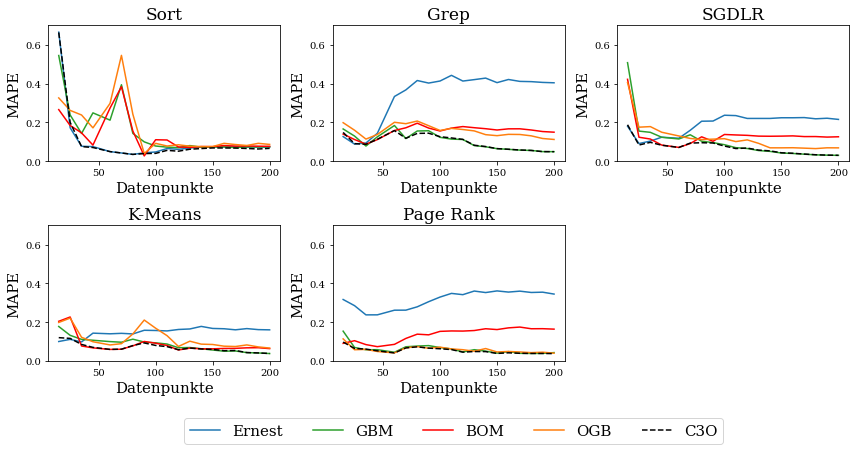

In [14]:
ff = 'DejaVu Sans'
ff = 'DejaVu Serif'
matplotlib.rc('font', family=ff)

model_names = list(map(lambda m:m.name, models))

colors = ['tab:blue', 'tab:green', 'red', 'tab:orange', 'black']

plt.figure(figsize=(12,8))
for i, job in enumerate(jobs):
    results = read_results(job.name)
    plt.subplot(3,3,i+1)
    plt.title(job.name, fontsize=17)
    for j, model_name in enumerate(model_names):
        y = results.loc[model_name][:]
        x =  results.loc[model_name].keys()
        line = plt.plot(x, y, '--' if model_name=='C3O' else '-', label=model_name, color=colors[j])
        
        plt.xlabel('Datenpunkte', fontsize=15)
        plt.ylabel('MAPE', fontsize=15)
        
        plt.ylim(0, .70)

plt.figlegend(model_names, fontsize=15, loc='upper right', ncol=5, bbox_to_anchor=[0.85, +.28], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('compression_kmeans.pdf', bbox_inches='tight')
plt.show()

## Display DBSCAN vs. KMEANS vs. KMEDOIDS

In [353]:
for job in jobs:
    results = pd.read_csv('compression_results_kmeans_filter.csv', header=None)
    rres = [(job, model, ds, float(mape)) for job, model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Job', 'Model', 'Compression', 'MAPE'))
    groups = df.groupby(by=['Job', 'Model', 'Compression'], as_index=False)
    df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df[df['Job'] == job.name].set_index(['Model', 'Compression'])

c3oResults = df[df['Model'] == 'C3O'].iloc[::-1]
with open('dbscan_vs_kmeans.csv', 'at') as f:
    for i in range(5):
        f.write(f"{'C3O-KMEANS'},{i},{c3oResults.iloc[i::5, :].mean().values[1]}\n")
        print(c3oResults.iloc[i::5, :].mean().values[1])

0.036211353158150515
0.0352092553064755
0.04973084570946493
0.08460593626917776
0.13744463035560406


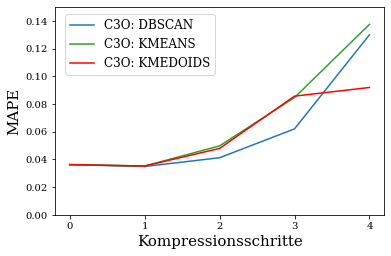

In [83]:
Model = collections.namedtuple('Model', ['name', 'predictor', 'kwargs'])

models = [
          Model('C3O: DBSCAN', C3OPredictor, {}),
          Model('C3O: KMEANS', C3OPredictor, {}),
          Model('C3O: KMEDOIDS', C3OPredictor, {}),
         ]

def read_results_all_jobs():
    try: results = pd.read_csv('dbscan_vs_kmeans_vs_kmedoids.csv', header=None)
    except: return

    rres = [(model, ds, float(mape)) for model, ds, mape in results.values]
    df = pd.DataFrame(rres, columns = ('Model', 'Compression', 'MAPE'))
    groups = df.groupby(by=['Model', 'Compression'], as_index=False)
    df = groups.mean()
    # Filter info for just the job we are interested in
    jobdf = df.set_index(['Model', 'Compression'])
    # Remove redundant info
    return jobdf.unstack()['MAPE']

ff = 'DejaVu Sans'
ff = 'DejaVu Serif'
matplotlib.rc('font', family=ff)

model_names = list(map(lambda m:m.name, models))

colors = ['tab:blue', 'tab:green', 'red', 'tab:orange', 'black']

plt.figure(figsize=(13,13))
results = read_results_all_jobs()
plt.subplot(3,2,1)
#plt.title('Vergleich der Verfahren', fontsize=17)
for j, model_name in enumerate(model_names):
    y = results.loc[model_name][:]
    x = [0,1,2,3,4]
    line = plt.plot(x, y, label=model_name, color=colors[j])
    
    plt.xlabel('Kompressionsschritte', fontsize=15)
    plt.ylabel('MAPE', fontsize=15)
   # plt.xlim([0, 4])
    plt.xticks(np.arange(0, 5, 1))
    plt.ylim(0, .15)
    
plt.figlegend(model_names, fontsize=12, loc='center left', bbox_to_anchor=[0.13, +.84], 
              bbox_transform=plt.gcf().transFigure)
plt.savefig('dbscan_vs_kmeans_vs_kmedoids.pdf', bbox_inches='tight')
plt.show()